In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from torch import nn
import torch.utils.data as data
from torchvision import transforms
from random import sample
from PIL import Image, ImageFile
import os
from tqdm import tqdm
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import nn
import torch
import os
import logging
import numpy as np
import math

In [3]:
root = '/content/drive/MyDrive/CS4644_project/data/train'
test_path = '/content/drive/MyDrive/CS4644_project/data/test'
batchsize = 16
model_path =  '/content/drive/MyDrive/CS4644_project/model'
output_path = '/content/drive/MyDrive/CS4644_project/model'

In [11]:
class MrCNN(nn.Module):
    def conv_block(self, channels):
        convs = [nn.Conv2d(channels, channels, 3, 1, 1), nn.ReLU(True)] * 6
        return nn.Sequential(*convs)

    def up_conv_block(self, *channels):
        layer_nums = len(channels) - 1
        up_convs = []
        for num in range(layer_nums):
            up_convs += [nn.ConvTranspose2d(channels[num], channels[num + 1],
                                            4, 2, 1), nn.ReLU(True)]
        up_convs += [nn.Conv2d(32, 3, 3, 1, 1)]
        return nn.Sequential(*up_convs)

    def __init__(self):

        super().__init__()

        self.s11 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, 1, 1)
        )
        self.s12 = self.up_conv_block()
        self.bn1 = nn.BatchNorm2d(32)
        self.s13 = self.conv_block(32)

        self.s21 = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 1, 1)
        )
        self.s22 = self.up_conv_block(64, 32)
        self.bn2 = nn.BatchNorm2d(64)
        self.s23 = self.conv_block(64)

        self.s31 = nn.AvgPool2d(2, 2)
        self.s32 = self.up_conv_block(64, 64, 32)
        self.bn3 = nn.BatchNorm2d(64)
        self.s33 = self.conv_block(64)

        self.s41 = nn.AvgPool2d(2, 2)
        self.s42 = self.up_conv_block(64, 64, 32, 32)
        self.bn4 = nn.BatchNorm2d(64)
        self.s43 = self.conv_block(64)

        self.s51 = nn.AvgPool2d(2, 2)
        self.s52 = self.up_conv_block(64, 64, 32, 32, 32)
        self.bn5 = nn.BatchNorm2d(64)
        self.s53 = self.conv_block(64)

        self.weight1 = nn.Parameter(torch.ones(1))
        self.weight2 = nn.Parameter(torch.ones(1))
        self.weight3 = nn.Parameter(torch.ones(1))
        self.weight4 = nn.Parameter(torch.ones(1))
        self.weight5 = nn.Parameter(torch.ones(1))

    def forward(self, x):
        x1 = self.s11(x)
        x2 = self.s21(x1)
        x3 = self.s31(x2)
        x4 = self.s41(x3)
        x5 = self.s51(x4)

        x1 = self.s12(self.s13(self.bn1(x1)))
        x2 = self.s22(self.s23(self.bn2(x2)))
        x3 = self.s32(self.s33(self.bn3(x3)))
        x4 = self.s42(self.s43(self.bn4(x4)))
        x5 = self.s52(self.s53(self.bn5(x5)))

        x = self.weight1 * x1 + self.weight2 * x2 + self.weight3 * x3 + self.weight4 * x4 + self.weight5 * x5
        return x

In [5]:
class MoirePic(data.Dataset):
    def __init__(self, rootX, rootY, training=True):
        self.picX = [os.path.join(rootX, img) for img in os.listdir(rootX)]
        self.picY = [os.path.join(rootY, img) for img in os.listdir(rootY)]
        self.picX.sort()
        self.picY.sort()
        self.pics = list(zip(self.picX, self.picY))
        # self.pics = self.pics[:400]
        self.Len = len(self.pics)

        if not training:
            self.pics = sample(self.pics, self.Len // 10)
            self.Len = len(self.pics)

    def __getitem__(self, index):
        tf = transforms.Compose([
            #transforms.CenterCrop(256),
            transforms.ToTensor()
        ])

        path_pair = self.pics[index]
        imgX, imgY = Image.open(path_pair[0]), Image.open(path_pair[1])
        return tf(imgX), tf(imgY)

    def __len__(self):
        return self.Len


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(mean=0.0, std=0.01)
        m.bias.data.fill_(0)


if __name__=='__main__':
    # you need to clean the training set
    input_path = os.path.join(root, 'input_train')
    gt_path = os.path.join(root, 'gt_train')
    input_imgs = [os.path.join(input_path, img) for img in os.listdir(input_path)]
    gt_imgs = [os.path.join(gt_path, img) for img in os.listdir(gt_path)]
    print(len(input_imgs))
    print(len(gt_imgs))
    input_imgs.sort()
    gt_imgs.sort()
    

    cot = 0
    loop = tqdm(enumerate(input_imgs), total=len(input_imgs), leave=False)
    print(len(loop))
    for idx, img in loop:
        with open(img, "rb") as f:
            ImPar=ImageFile.Parser()
            chunk = f.read(2048)
            count=2048
            while chunk != "":
                ImPar.feed(chunk)
                if ImPar.image:
                    break
                chunk = f.read(2048)
                count+=2048
            M, N = ImPar.image.size[0], ImPar.image.size[1]

        if M < 512 or N < 512:
            os.remove(input_imgs[idx])
            print(idx)
            os.remove(gt_imgs[idx])
            cot += 1
        
        loop.set_postfix(unfit_imgs=cot)

    print("Done! Get %d unfit images." % cot)

1082
1082


  0%|          | 0/1082 [00:00<?, ?it/s, unfit_imgs=0]

1082


Done! Get 0 unfit images.


In [7]:
torch.cuda.set_device(0)

def train(model, train_loader, criterion, epoch, lr, use_gpu):
    model.train()

    # loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_gpu:
            data, target = data.cuda(
                non_blocking=True), target.cuda(non_blocking=True)
        data, target = Variable(data), Variable(target)

        optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, weight_decay=0.00001)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # loop.set_description(f'Train Epoch [{epoch}/50]')
        # loop.set_postfix(loss = loss.item())
        if batch_idx % 10 == 0:
            logging.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


def val(model, val_loader, epoch, use_gpu):
    model.eval()

    idx, loss_sum = 0, 0.0
    criterion = nn.MSELoss()

    for (data, target) in val_loader:
        if use_gpu:
            data, target = data.cuda(
                non_blocking=True), target.cuda(non_blocking=True)
        data, target = Variable(data), Variable(target)

        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)

        loss_sum += loss.item()
        idx += 1
    loss_sum /= idx

    logging.info('Val Epoch: {} \tLoss: {:.6f}'.format(
        epoch, loss_sum))

    return loss_sum

In [13]:
dataset = MoirePic(os.path.join(root, 'input_train'),
                    os.path.join(root, 'gt_train'))
valdataset = MoirePic(os.path.join(root, 'input_train'),
                        os.path.join(root, 'gt_train'), False)

use_gpu = torch.cuda.is_available()
train_loader = DataLoader(dataset=dataset, shuffle=True, batch_size= batchsize,
                            num_workers=14, pin_memory=True)
val_loader = DataLoader(dataset=valdataset, shuffle=True, batch_size=batchsize,
                        num_workers=14, pin_memory=True)
logging.info('loaded dataset successfully!')
logging.info(f'the number of training set images: {dataset.__len__()}')

model = MrCNN()
model.apply(weights_init)
# model = torch.load("moire_best.pth")

if use_gpu:
    model = model.cuda()
    # model = nn.DataParallel(model)
    logging.info('use GPU')
else:
    print('use CPU')

criterion = nn.MSELoss()
lr = 0.0001
best_loss, last_loss = 100.0, 100.0

logging.info(f'learning rate: {lr}, batch size: {batchsize}')


In [9]:
loss = []
current = [3,4]
print(loss+current)

[3, 4]


In [14]:
import copy

val_loss = []
best_model = None
for epoch in range(20):
    train(model, train_loader, criterion, epoch, lr, use_gpu)
    current_loss = val(model, val_loader, epoch, use_gpu)
    val_loss+=[current_loss]
    if current_loss < best_loss:
        best_loss = current_loss
        #torch.save(model, os.path.join(output_path, 'moire_avgpool.pth'))
        best_model = copy.deepcopy(model)
    if current_loss > last_loss:
        lr *= 0.9

    last_loss = current_loss

Train Epoch: 0 [0/1082 (0%)]	Loss: 0.372157
Train Epoch: 0 [160/1082 (15%)]	Loss: 0.402111
Train Epoch: 0 [320/1082 (29%)]	Loss: 0.337265
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.090359
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.088015
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.099379
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.148180
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.113699
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.068908
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.128378
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.069281
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.039009
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.073958
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.061452
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.061445
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.066302
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.056652
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.038196
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.040959
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.041053
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.236791
Train Epoch: 3 [0/1082

In [18]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret

In [17]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window

# helper function to load images
load_images = lambda x: np.asarray(Image.open(x).resize((480, 640)))

# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display imgs 
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (400, 400))
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)

In [22]:
import matplotlib.pyplot as plt

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 10 * math.log10(1 / mse)

dataset = MoirePic(os.path.join(test_path, 'input_test'),
                    os.path.join(test_path, 'gt_test'))
test_loader = DataLoader(dataset=dataset, batch_size=4, drop_last=False)
# you can change batchsize to get a faster speed
#model = torch.load('/content/drive/MyDrive/CS4644_project/model/mrnet_moire_best.pth')
# model = MRNet()
# model.load_state_dict(torch.load('/content/drive/MyDrive/CS4644_project/model/mrnet_moire_best.pth'))
model = best_model
model.eval()

psnr_all, count = 0.0, 0
loop = tqdm(enumerate(test_loader), total=len(test_loader), leave=False)
ssim_vals = []

for idx, (data, target) in loop:
    data, target = data.cuda(), target.numpy()

    with torch.no_grad():
        output = model(data).cpu().numpy()
    if (idx == 0):
      orig = data.cpu().numpy()
      fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(128, 128))
      img_pred = np.transpose(output[1],(1,2,0))
      img_gt = np.transpose(target[1],(1,2,0))
      img_orig = np.transpose(orig[1], (1,2,0))
      ax1.imshow(img_orig)
      ax2.imshow(img_gt)
      ax3.imshow(img_pred)
      plt.show()
    
    for i in range(target.shape[0]):
        psnr_all += psnr(output[i], target[i])
        img1 = tensorify(output[i])
        img2 = tensorify(target[i])
        ssim_val = ssim(img1, img2, val_range=255)
        ssim_vals.append(ssim_val)

    count += target.shape[0]
    loop.set_postfix(average_psnr=psnr_all / count)

average_ssim = sum(ssim_vals) / len(ssim_vals)

print('')
print(f'testing dataset SSIM: {average_ssim}')
print(f'testing dataset PSNR: {psnr_all / count}')

Output hidden; open in https://colab.research.google.com to view.

range(0, 20)


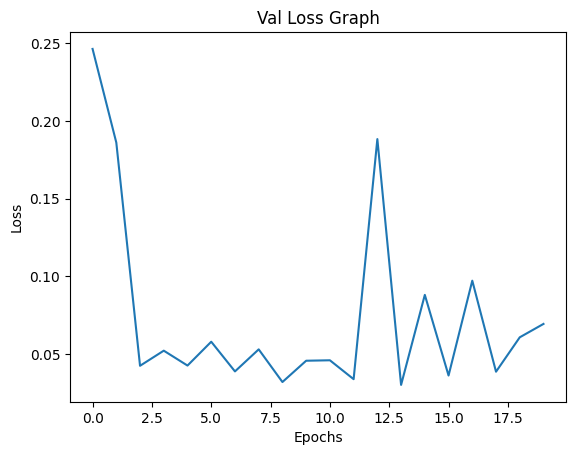

In [29]:
epochs = range(len(val_loss))
print(epochs)
plt.plot(epochs, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Val Loss Graph")
plt.show()